 # UDACITY - VEHICLE DETECTION PROJECT



#### Hiep Truong Cong

### Content
1. Includes
2. Feature extraction
    + Color feature extraction
    + Historgram fearture extraction
    + HOG feature extraction
    + Combination of extracted features
3. Training a classifier
    + Prepare training data
    + Normalize the traing data
    + Training the classifier
    + Evaluate the classifier
4. Sliding window search
    + Sliding window
    + Classifier at a single scale
    + Classify with multi-scale windows
    + Combine detected windows
5. Video pipeline

## 1. Includes

In [20]:
from Training_Model import *
from lesson_functions import *
import matplotlib.image as mpimg
from Finding_Car import *
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## 2. Feature extraction

#### Read image data

The number of vehicle images is 8792.
The number of non-vehicle images is 8968.


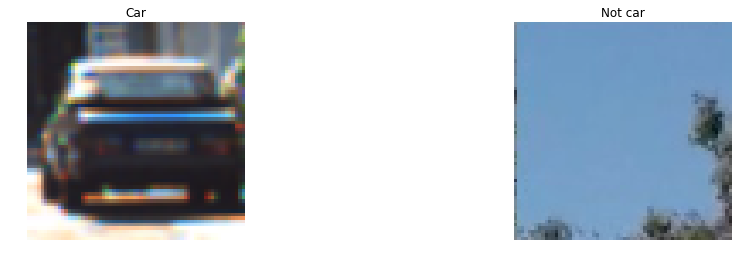

In [22]:
dirName = './FeatureSetBig'
cars, notcars = Read_Data(dirName)
print('The number of vehicle images is {}.'.format(len(cars)))
print('The number of non-vehicle images is {}.'.format(len(notcars)))
car_example = mpimg.imread(cars[0])
notcar_example = mpimg.imread(notcars[0])
Plot_Images([car_example, notcar_example], 2, title = None, sub_plt_titles = ['Car', 'Not car'])

#### Color feature extraction

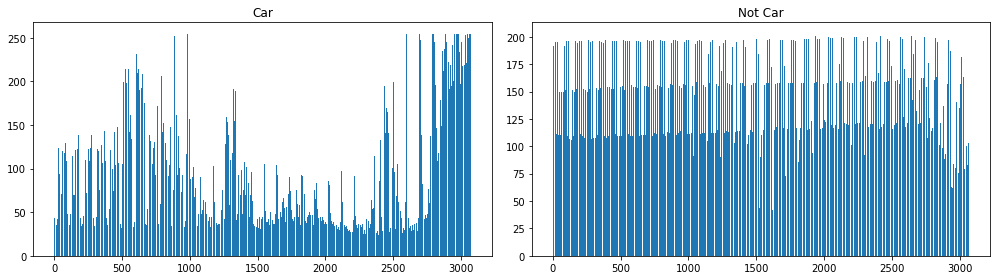

In [23]:
car_example = dtype2uint8(car_example)
notcar_example = dtype2uint8(notcar_example)
car_color_feature = bin_spatial(car_example)
notcar_color_feature = bin_spatial(notcar_example)

Subplot_Barchart(ydata =[range(len(car_color_feature)), range(len(notcar_color_feature))], 
                 xdata = [car_color_feature, notcar_color_feature],
                 titles = ['Car', 'Not Car'], 
                 number_diagram_per_row = 2)

#### Histogram feature extraction

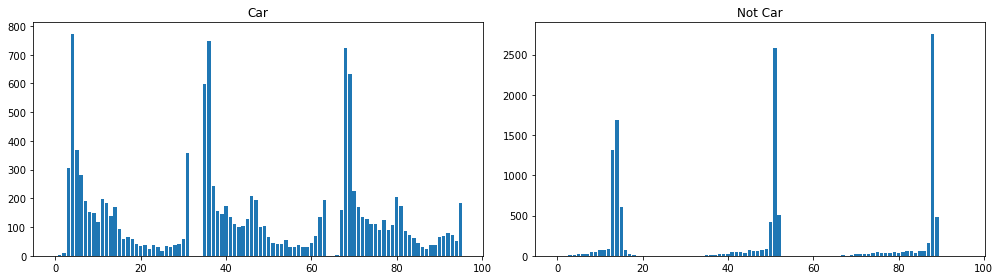

In [4]:
car_example = dtype2uint8(car_example)
notcar_example = dtype2uint8(notcar_example)

car_hist_feat = color_hist(car_example)
notcar_hist_feat = color_hist(notcar_example)

Subplot_Barchart(ydata =[range(len(car_hist_feat)), range(len(notcar_hist_feat))], 
                 xdata = [car_hist_feat, notcar_hist_feat],
                titles = ['Car', 'Not Car'], number_diagram_per_row = 2)

#### HOG feature

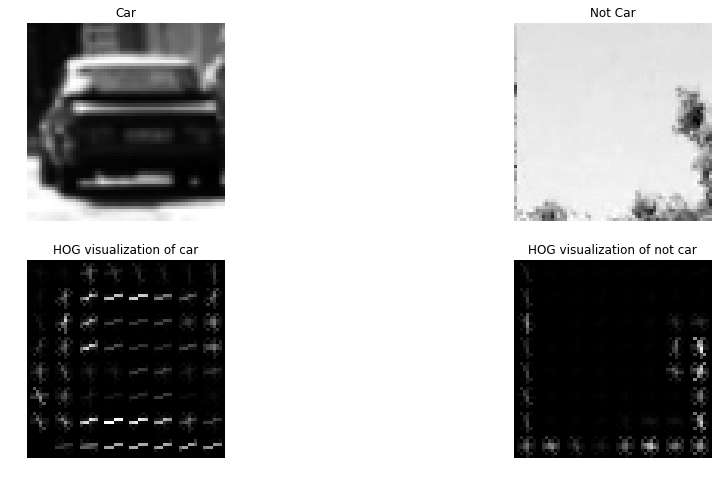

In [24]:
car_example1 = mpimg.imread(cars[0])
notcar_example1 = mpimg.imread(notcars[0])
car_gray = cv2.cvtColor(car_example1, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar_example1, cv2.COLOR_RGB2GRAY)
Hog_car_example, hog_img_car = get_hog_features(car_example1[:,:,0], 9, 8,2, vis=True)
Hog_notcar_example, hog_img_notcar = get_hog_features(notcar_gray, 9, 8,2, vis=True)

Plot_Images([car_gray,notcar_gray,hog_img_car, hog_img_notcar], number_img_per_row = 2, title = None,
            sub_plt_titles  = ['Car', 'Not Car', 'HOG visualization of car', 'HOG visualization of not car'])

#### Combination of extracted features

In [25]:
car_feature_combined = extract_features(cars[0])
notcar_feature_combined = extract_features(notcars[0])

PermissionError: [Errno 13] Permission denied: '.'

## 3. Training a classifier

* Transform the data images into feature space
* Training a support vector machine classifier
* Test its performance

#### Tranform data images into feature space

In [26]:
color_space = 'YUV'
spatial_size=(32,32)
hist_bins=32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"
spatial_feat=True
hist_feat=True
hog_feat=True

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

#### Training a support vector machine classifier

In [27]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)
        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

####  Test SVC classifier performance

In [28]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.989
My SVC predicts:  [1. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
For these 10 labels:  [1. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
0.02 Seconds to predict 10 labels with SVC


## 4. Sliding window search

#### Slide window

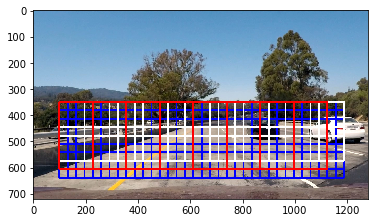

In [44]:
image = mpimg.imread('./test_images/test1.jpg')


window_list1 = slide_window(image, x_start_stop=[100, 1200], y_start_stop=[350, 650], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

window_list2 = slide_window(image, x_start_stop=[100, 1200], y_start_stop=[350, 650], 
                    xy_window=(128, 128), xy_overlap=(0.25, 0.25))

window_list3 = slide_window(image, x_start_stop=[100, 1200], y_start_stop=[350, 650], 
                    xy_window=(256, 256), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(image, window_list1, color = (0,0,255))
window_img = draw_boxes(window_img, window_list2, color = (255,255,255))
window_img = draw_boxes(window_img, window_list3, color = (255,0,0))

plt.imshow(window_img)
plt.show()

#### Classify at a single scale


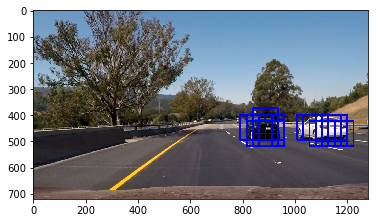

In [63]:
image = mpimg.imread('./test_images/test6.jpg')
scale = 1.5
ystart= 350
ystop = 650

rectangles = find_cars(image, color_space, 
                       ystart, ystop, 
                       scale, svc, 
                       X_scaler, orient, 
                       pix_per_cell, cell_per_block, 
                       spatial_size, hist_bins)

window_img = draw_boxes(image, rectangles, color = (0,0,255))
plt.imshow(window_img)
plt.show()

#### Classify with multi-scale windows

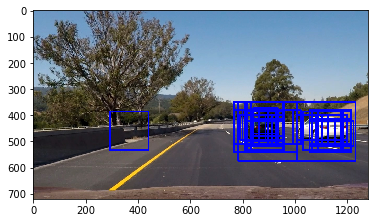

In [64]:
scales = [1.5,2.0, 2.3, 2,7, 3.0,3.5]
out_rectangles = Find_Car_Multi_Scale(scales, image, color_space, 
                                        ystart, ystop, 
                                        svc, X_scaler, 
                                        orient, 
                                        pix_per_cell, cell_per_block, 
                                        spatial_size, hist_bins)

window_img = draw_boxes(image, out_rectangles, color = (0,0,255))
plt.imshow(window_img)
plt.show()

#### Combine detected windows

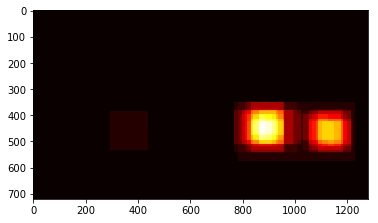

In [65]:
heat_map = add_heat(image, out_rectangles)
plt.imshow(heat_map, cmap='hot')
plt.show()

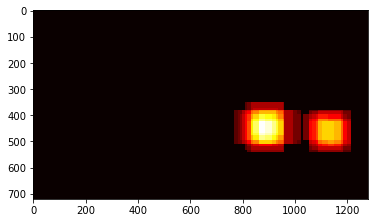

In [66]:
heat_map_thresholded = apply_threshold(heat_map, 2)
plt.imshow(heat_map_thresholded, cmap='hot')
plt.show()

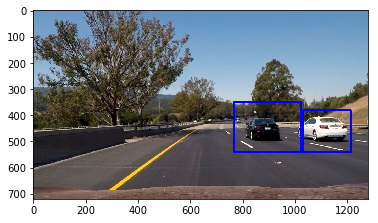

In [70]:
heatmap = np.clip(heat_map_thresholded, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes((image), labels)
plt.imshow(image)
plt.show()

#### Image pipeline

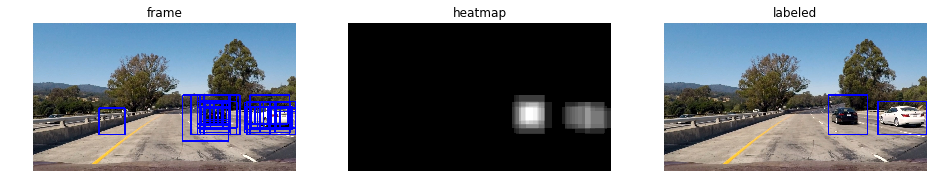

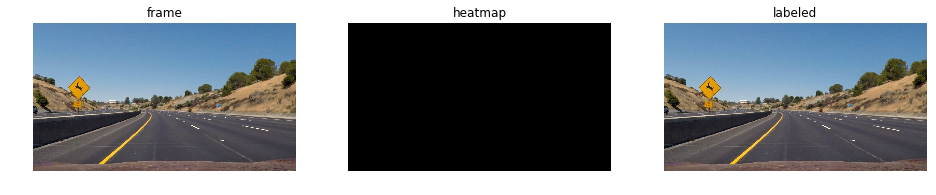

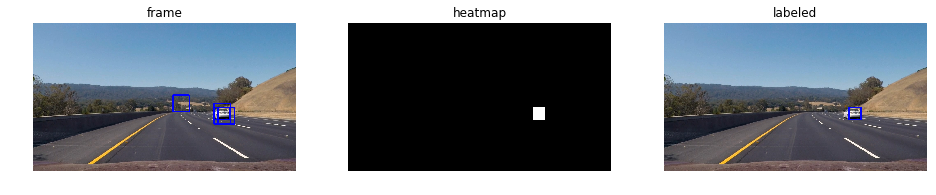

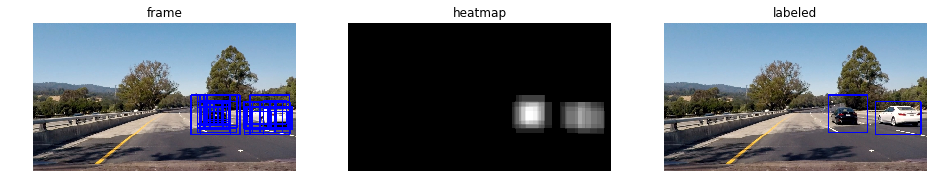

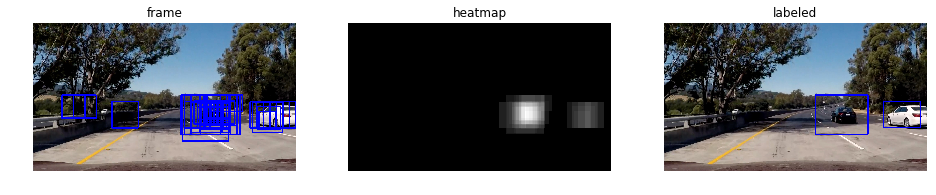

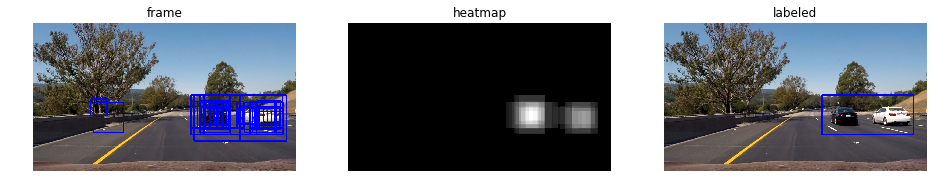

In [78]:
import glob

image = mpimg.imread('./test_images/test6.jpg')
def image_pipeline(image):
    scales = [1.25, 1.75, 2.0, 2.3, 2,7, 3.0,3.5]
    out_rectangles = Find_Car_Multi_Scale(scales, image, color_space, 
                                        ystart, ystop, 
                                        svc, X_scaler, 
                                        orient, 
                                        pix_per_cell, cell_per_block, 
                                        spatial_size, hist_bins)
    heat_map = add_heat(image, out_rectangles)
    heat_map_thresholded = apply_threshold(heat_map, 2)
    heatmap = np.clip(heat_map_thresholded, 0, 255)
    labels = label(heatmap)
    draw_img1 = draw_labeled_bboxes((image), labels)
    window_img = draw_boxes(image, out_rectangles, color = (0,0,255))
    Plot_Images([window_img, heat_map_thresholded, image], 3, title = None, sub_plt_titles  = ["frame", "heatmap", "labeled"])

images = glob.glob('./test_images' + '/*.jpg')

for image_name in images:
    image = mpimg.imread(image_name)
    image_pipeline(image)

## 5. Video pipeline

In [44]:
def Find_Car_In_Frame(img):
    global svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart, ystop, scales, colorspace, buffer, heatmap_threshold
    out_rectangles = Find_Car_Multi_Scale(scales, img, colorspace, 
                                          ystart, ystop, 
                                          svc, X_scaler, 
                                          orient, 
                                          pix_per_cell, cell_per_block, 
                                          spatial_size, hist_bins)
    buffer.push_wins(out_rectangles)
    rectang = buffer.get_concate()
    heat_map = add_heat(img, rectang)
    heatmap_img = apply_threshold(heat_map, heatmap_threshold)
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

def Processing_video(input_video, output_video):
    clip1 = VideoFileClip(input_video)
    white_clip = clip1.fl_image(Find_Car_In_Frame)
    white_clip.write_videofile(output_video, audio=False)


svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins = ReadSvcFromPickle('Svm.pkl')
ystart = 300
ystop = 700
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
scales = [1.5,2.0, 2.3, 2,7, 3.0,3.5]
heatmap_threshold = 3
buffer = Window_buf(10)

input_project_video = './test_videos/test_video.mp4'
file_name =  input_project_video.replace('./test_videos/', '')
output_project_video = 'output_' + file_name


Processing_video(input_project_video, output_project_video)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
StandardScaler(copy=True, with_mean=True, with_std=True)
orient  9
pix_per_cell  8
cell_per_block  2
spatial_size  (16, 16)
hist_bins  32
[MoviePy] >>>> Building video output_test_video.mp4
[MoviePy] Writing video output_test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:31<00:02,  2.41s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video.mp4 



In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_project_video))

In [59]:
import cv2
input_video = './test_videos/challenge.mp4'
file_name =  input_video.replace('./output_videos/', '')
file_name =  file_name.replace('.mp4', '')
cap = cv2.VideoCapture(input_video)
frames_to_extract = [1,2,3,4,5]
frame_number = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        if frame_number in frames_to_extract:
            file_name_to_write = './extracted/' + file_name + str(frame_number) + '.jpg'
            cv2.imwrite(file_name_to_write, frame)
            frame_number = frame_number + 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        print("false")
        break

false
